In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from astropy.table import Table
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup

#05/21/2025
#Need to get uncertainty using stochastic variation in each flux

In [2]:
def try_float(x):
    '''Try to convert item to float, if that fails, leave it as the type that it is, likely a string
    -------------
    Parameters
    -------------
    x : type = variable - item to be converted to float if possible
    
    Returns
    -------------
    item passed as argument, converted to float if it can be
    '''
    try:
        return float(x)
    except ValueError:
        return x


def import_data_and_sort_by_wavelength(file_path):
    '''import data from data file_path and sort by wavelength'''
    with open(file_path, 'r') as file:
        header = file.readline().strip().split()
        
        # Process lines with proper float conversion
        data_list = []
        for line in file:
            parts = line.strip().split(maxsplit=4)
            # Convert wavelength to float FIRST
            parts[0] = float(parts[0])  # Ensures numeric sorting
            # Pad with nan if needed
            parts = parts + [np.nan] * (5 - len(parts))
            data_list.append(parts)
    
    # Convert to numpy array
    data = np.array(data_list, dtype=object)
    
    # Sort by wavelength column (now guaranteed numeric)
    sort_idx = np.argsort(data[:, 0].astype(float))
    sorted_data = data[sort_idx]
    
    return sorted_data



def gaussian_func(x, amplitude, xmean, stddev):
    '''classic gaussian profile

    -------------

    Parameters
    -------------
    x :  type = float - value to be passed on the x-axis to get a y-axis value
    amplitude :  type = float - maximum height of the gaussian
    xmean : type = float - line center
    stddev : type = float - standard deviation of the gaussian
    
    Returns
    -------------
    A single y-value based on the given x-value and other parameters
    '''
    return (amplitude * np.exp(-0.5 * ((x - xmean) / stddev)**2))


def voigt(x, amp, center, sigma, gamma):
    '''classic voigt profile

    -------------

    Parameters
    -------------
    x :  type = float - value to be passed on the x-axis to get a y-axis value
    amp :  type = float - maximum height of the voigt
    center : type = float - line center
    sigma : type = float - standard deviation of the Gaussian contribution
    gamma : type = float - Full Width Half Max of the Lorenzian contribution

    Returns
    -------------
    A single y-value based on the given x-value and other parameters
    '''
    profile = voigt_profile(x - center, sigma, gamma)
    return amp * profile / np.max(profile)


import numpy as np

def get_continuum_around(wavelength_array, flux_array, feature_mask_array, feature_index):
    '''Calculates the surrounding continuum around a feature.

    -------------
    Parameters
    -------------
    wavelength_array : array - array of wavelengths
    flux_array : array - array of flux values
    feature_mask_array : boolean array - True for feature pixels, False for continuum
    feature_index : int - center (or near center) index of the feature

    Returns
    -------------
    mean_cont : float - Average continuum flux value of surrounding wavelengths
    left_cont : float - Average continuum flux value to the left of the feature
    right_cont : float - Average continuum flux value to the right of the feature
    stdev : float - Standard deviation of the surrounding continuum (for noise estimate)
    '''

    #Continuum left of the feature
    left_continuum_indices = []
    i = feature_index - 1
    while len(left_continuum_indices) < 12:
        if not feature_mask_array[i]:
            left_continuum_indices.append(i)
        i -= 1

    #Continuum right of the feature
    right_continuum_indices = []
    i = feature_index + 1
    while len(right_continuum_indices) < 12:
        if not feature_mask_array[i]:
            right_continuum_indices.append(i)
        i += 1

    #Get all the flux values for the continuum
    left_continuum = flux_array[left_continuum_indices]
    right_continuum = flux_array[right_continuum_indices]

    #Calculate statistics
    left_cont = np.mean(left_continuum)
    right_cont = np.mean(right_continuum)
    mean_cont = np.mean([left_cont, right_cont])
    stdev = np.std(np.concatenate((left_continuum, right_continuum)))

    return mean_cont, left_cont, right_cont, stdev




def make_feature_table(wavelengths, fluxes, feature_mask, notes):
    '''groups all the wavelengths with a 1 in the 4th column that are adjacent to a note under one single feature

    -------------

    Parameters
    -------------
    wavelengths :  type = array - array of wavelengths including features
    fluxes :  type = array - flux for each of those wavelegnths
    mask : type = boolean array - 1 if there is a feature at this wavelength, 0 if this is continuum
    notes : type = str - will be nan if there is no note
    
    Returns
    -------------
    features grouped together
    '''    
    feature_table = pd.DataFrame(columns=['wavelengths', 'fluxes'])
    
    j = 0
    for i in range(len(wavelengths)):
        if i < j:
            continue
        if feature_mask[i]:

            j = i
            feature_wls = [wavelengths[j-2], wavelengths[j-1]]
            feature_flux = [fluxes[j-2], fluxes[j-1]]
    
            while feature_mask[j]:
                if notes[j] != 'nan':
                    feature_name = notes[j]
                feature_wls.append(wavelengths[j])
                feature_flux.append(fluxes[j])
                j += 1
    
            feature_wls.append(wavelengths[j])
            feature_wls.append(wavelengths[j+1])
            feature_flux.append(fluxes[j])
            feature_flux.append(fluxes[j+1])
    
            # Append new row to the table
            feature_table.loc[feature_name] = [np.array(feature_wls), np.array(feature_flux)]

    return feature_table

def get_feature_WL_and_flux(wavelengths, fluxes, flux_uncertainties, feature_mask, notes):
    '''groups all the wavelengths with a 1 in the 4th column that are adjacent to a note under one single feature

    -------------

    Parameters
    -------------
    wavelengths :  type = array - array of wavelengths including features
    fluxes :  type = array - flux for each of those wavelegnths
    mask : type = boolean array - 1 if there is a feature at this wavelength, 0 if this is continuum
    notes : type = str - will be nan if there is no note
    
    Returns
    -------------
    features grouped together
    '''    
    features_WL = []
    features_fluxes = []
    features_flux_unc = []
    features_names = []
    feature_idx = []
    
    j = 0
    for i in range(len(wavelengths)):
        if i < j:
            continue
        if feature_mask[i]:
            current_feature_WL = []
            current_feature_flux = []
            current_features_flux_unc = []
            j = i

            while feature_mask[j]:
                if notes[j] != 'nan':
                    features_names.append(notes[j])
                    feature_idx.append(j)
                current_feature_WL.append(wavelengths[j])
                current_feature_flux.append(fluxes[j])
                current_features_flux_unc.append(flux_uncertainties[j])
                j += 1
            features_WL.append(current_feature_WL)
            features_fluxes.append(current_feature_flux)
            features_flux_unc.append(current_features_flux_unc)
    return     features_WL, features_fluxes, features_names, feature_idx, features_flux_unc

def pull_wavelength_data_from_NIST():
    '''grabs the rest wavelengths from NIST. You must go to https://physics.nist.gov/PhysRefData/ASD/lines_form.html and manually change the following:
    Spectrum : HI
    Output Wavelengths : micrometers
    Lower: 0.9
    Upper: 30
    Format output: ASCII
    Wavelength in: vacuum all (maybe air all)
    Level information: uncheck Energies and J
    retrieve info, and copy url to this function below

    -------------

    Parameters
    -------------
    None
    
    Returns
    -------------
    array of rest wavelengths and array of two value lists representing [transition from, transition to
    '''   
    
    
    url = "https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=Hydrogen+I&output_type=0&low_w=0.96&upp_w=28.095&unit=2&de=0&plot_out=0&I_scale_type=1&format=1&line_out=0&remove_js=on&en_unit=0&output=0&bibrefs=1&page_size=100&show_obs_wl=1&show_calc_wl=1&unc_out=1&order_out=0&max_low_enrg=&show_av=3&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&submit=Retrieve+Data"
    #TJ this one uses air rest wavelengths, just to check
    #url = 'https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=Hydrogen+I&output_type=0&low_w=0.96&upp_w=28.095&unit=2&de=0&plot_out=0&I_scale_type=1&format=1&line_out=0&remove_js=on&en_unit=0&output=0&bibrefs=1&page_size=15&show_obs_wl=1&show_calc_wl=1&unc_out=1&order_out=0&max_low_enrg=&show_av=4&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&submit=Retrieve+Data'
    # Fetch the data
    response = requests.get(url)
    response.raise_for_status()  # Check for errors
    
    # Parse HTML table
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('pre')  # NIST outputs data in <pre> tags for ASCII format
    data_lines = table.text.split('\n')
    transitions = []
    wavelengths = []
    
    for line in data_lines:
        parts = line.split('|')
        
        # Only process lines that look like data (i.e., contain many fields)
        if len(parts) > 8:
    
            try:
                lower_bound = int(parts[7])
                upper_bound = int(parts[8])
                wavelengths.append(float(parts[2]))
            except ValueError:
                continue
            
            transitions.append([upper_bound, lower_bound])
    return wavelengths, transitions


        
def fit_voigt_to_all(WL, flux, flux_unc, feature_mask, trans_wl, transitions, guess_Z = 0.001534):
    '''Fits voigt profiles to all features

    -------------

    Parameters
    -------------
    WL :  type = array - array of wavelengths including features
    flux :  type = array - flux array representing flux at each wavelength
    flux unc : type = array - uncertainty in flux
    trans_wl : type = array - array with values representing the rest wavelengths of all transitions we are interested in getting fluxes for
    transitions : type = list of two integers - first entry in upper level, second entry is lower level
    guess_Z (optional, defaults to 0.0018) : type = float - estimate for redshift to correct rest wavelengths to observed wavelengths
    
    Returns
    -------------
    list of lists where the first entry in each index is the x-values, the second is the y-values describing the voigt function that fit the feature
    '''   
    voigt_funcs = [] #TJ initialize array of x,y data for each voigt function
    #TJ no longer needed
    #feature_WL, feature_flux, feature_name, feature_idx, feature_unc = get_feature_WL_and_flux(WL, flux, flux_unc, feature_mask, notes)
    for i in range(len(transitions)):
        estimated_obs_wl = trans_wl[i]*(1+guess_Z) #TJ correct for approx redshift
        center_idx = np.argmin(np.abs(WL - estimated_obs_wl)) #TJ assign the center index as the closest wavelength to the expected wavelength
        continuum, _, _, cont_std = get_continuum_around(WL, flux, feature_mask, center_idx) #TJ get continuum and continuum stddev
        idx_range = range(center_idx-3,center_idx+4)
        plt_range = range(center_idx-10,center_idx+11)
        x_data = WL[idx_range] #TJ generate the x data as the 20 nearest datapoints
        y_data = flux[idx_range] - continuum #TJ correct y-data for the net above continuum
        flux_uncertainty = flux_unc[idx_range] #TJ assign uncertainty array
        # Initial guesses
        amp_guess = max(flux[center_idx-1:center_idx+1]-continuum) if max(flux[center_idx-1:center_idx+1]-continuum) > 0 else 0
        mean_guess = WL[center_idx]
        width_guess = WL[center_idx+1] - WL[center_idx] if (1 > (WL[center_idx+1] - WL[center_idx]) > 0) else 0.001
        lower_amp = max(flux[center_idx-1:center_idx+1] - continuum) * 0.9
        upper_amp = max(flux[center_idx-1:center_idx+1] - continuum) * 1.1
        upper_amp = upper_amp if upper_amp > 0 else np.inf  # Handle non-positive cases
        
        bounds = (
            [lower_amp, WL[center_idx-2], 0, 0],  # Lower bounds
            [upper_amp, WL[center_idx+2], 1, 1]    # Upper bounds
        )
        
        params, cov = curve_fit(
            voigt,
            x_data,
            y_data,
            p0=[amp_guess, mean_guess, width_guess, width_guess],
            bounds=bounds,
            maxfev=5000
        )
        xrange = np.linspace(min(WL[plt_range]),max(WL[plt_range]), 1000) #TJ define high resolution xrange for plotting
        fitted = voigt(xrange, *params) #TJ create the fitted y-data
        total_feature_flux = np.trapz(fitted, xrange) #TJ integrate over fitted voigt to get total flux
        this_features_snr = params[0]/cont_std #TJ snr is just amp divided by the noise in continuum
        center_WL = params[1] #TJ assign center of the feature for redshift/velocity calculations
        this_feature_flux = flux[idx_range] 
        this_features_unc = flux_unc[idx_range]
        residuals = this_feature_flux - voigt(WL[idx_range], *params)
        chi2 = np.sum((residuals / this_features_unc)**2)
        dof = len(y_data) - len(params)
        reduced_chi2 = chi2 / dof
        if ((this_features_snr > 4) & (reduced_chi2/params[0] < 10)):
            tag = 2
        elif this_features_snr > 4:
            tag = 1
        else:
            tag = 0
        voigt_funcs.append([[xrange, fitted], total_feature_flux, center_WL, this_features_snr, chi2, reduced_chi2, [*params], tag])
        if show_plots:
            plt.plot(WL[plt_range], flux[plt_range]-continuum, label='Continuum-Subtracted', color='purple')
            plt.axvline(x=WL[center_idx])
            if tag == 2:
                plt.plot(xrange, fitted, color='blue', label=f'idx:{i} {transitions[i]}')
            elif tag == 1:
                plt.plot(xrange, fitted, color='green', label=f'idx:{i} chi2:{reduced_chi2:.2f} {transitions[i]}')
            else:
                plt.plot(xrange, fitted, color='red', label=f'idx:{i} {transitions[i]}')
            plt.legend()
            plt.show()
    return voigt_funcs

def get_feature_statistics(voigts, rest_wl_array, transitions):
    c = 2.99792458e+8
    fluxes = []
    center_wl = []
    velocities = []
    z_temp = []
    for i, feature in enumerate(voigts):
        fluxes.append(feature[1])
        center_wl.append(feature[2])
        rest = rest_wl_array[i]*(1e-6)
        obs = feature[2]*(1e-6)
        velocity = c*(obs-rest)/rest
        velocities.append(velocity)
        z_temp.append(((obs-rest)/rest))
    z = np.nanmedian(z_temp)
    return fluxes, center_wl, velocities, z

def get_z_v(index, trans_wl):
    c = 2.99792458e+8
    obs = feature_centers[index]
    rest = trans_wl[index]
    
    velocity = c*(obs-rest)/rest
    z = (obs-rest)/rest
    return velocity, z

def get_good_statistics(voigts, rest_wl_array, transitions):
    c = 2.99792458e+8
    fluxes = []
    center_wl = []
    velocities = []
    z_temp = []

    for i, feature in enumerate(voigts):
        if voigts[i][-1] < 1:
            continue
        fluxes.append(feature[1])
        center_wl.append(feature[2])
        rest = rest_wl_array[i]*(1e-6)
        obs = feature[2]*(1e-6)
        velocity = c*(obs-rest)/rest
        velocities.append(velocity)
        z_temp.append(((obs-rest)/rest))
    z = np.nanmedian(z_temp)
    return fluxes, center_wl, velocities, z

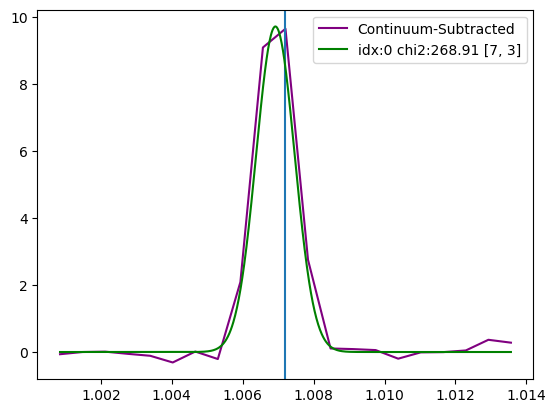

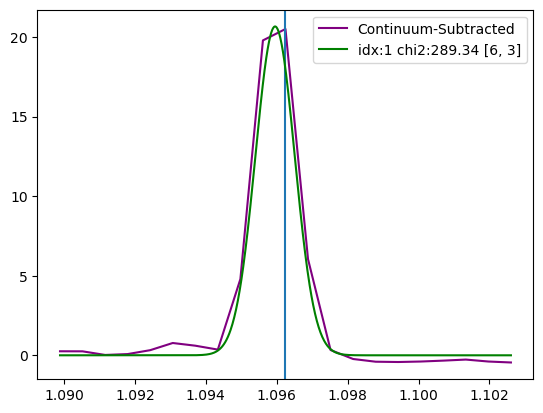

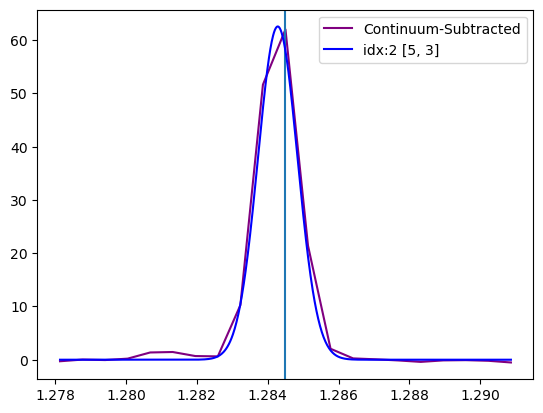

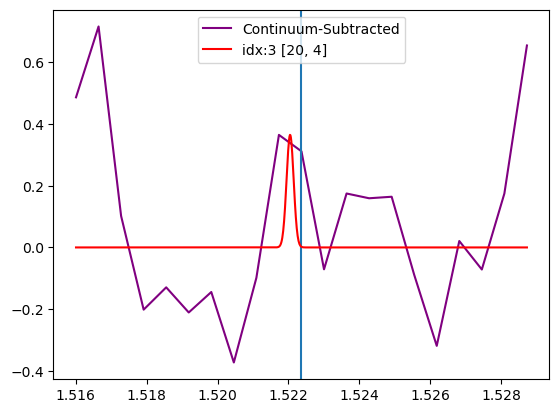

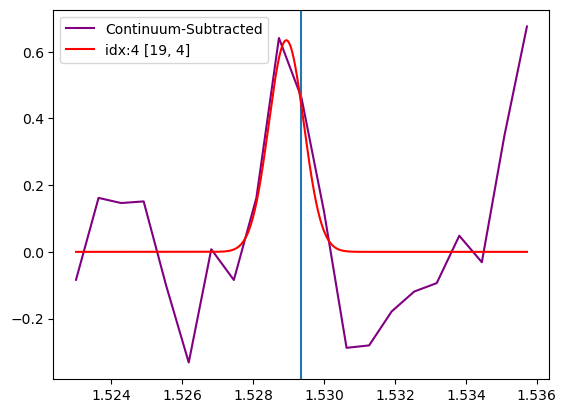

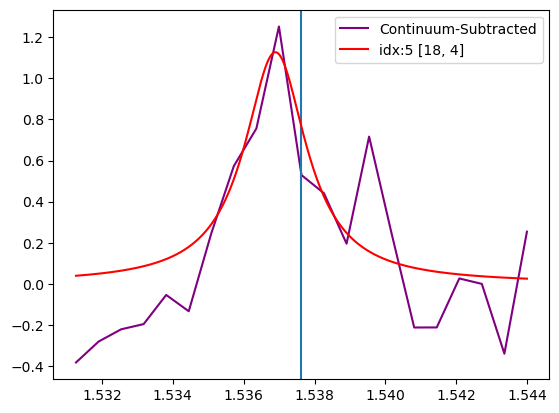

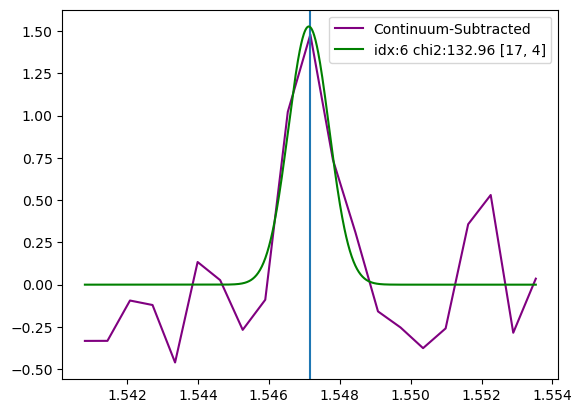

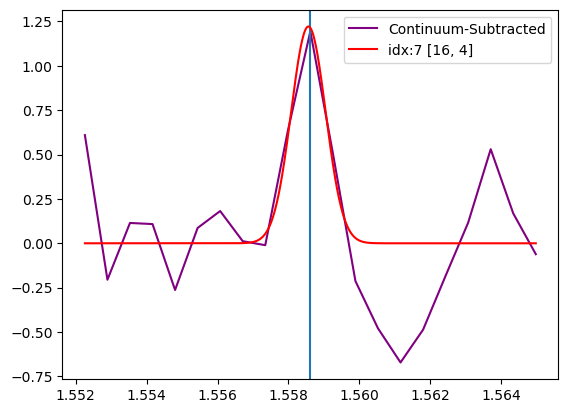

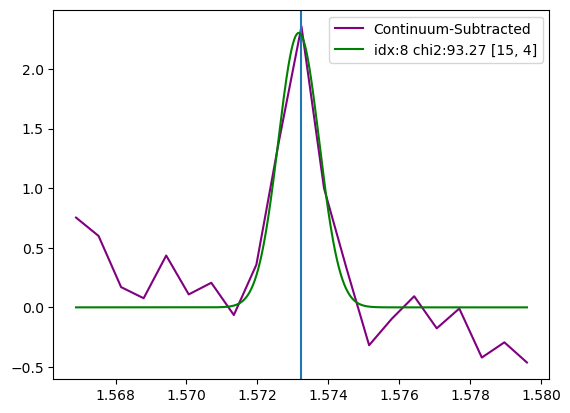

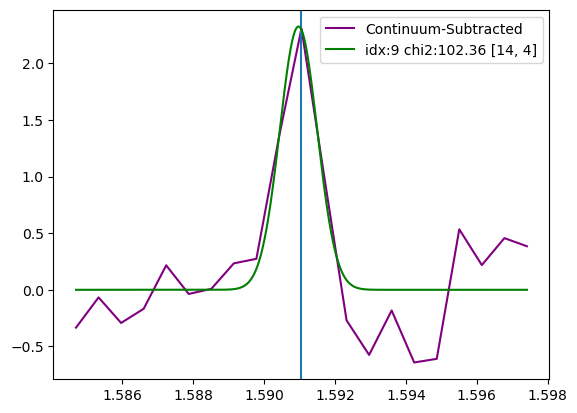

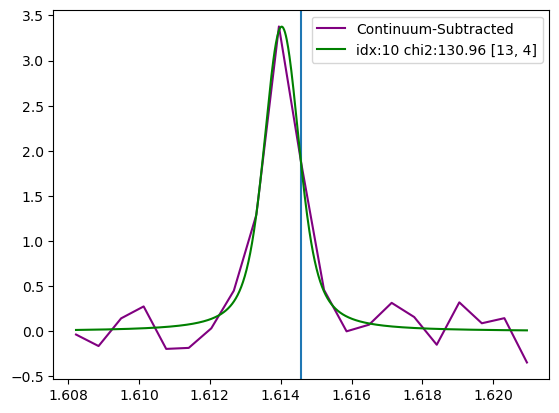

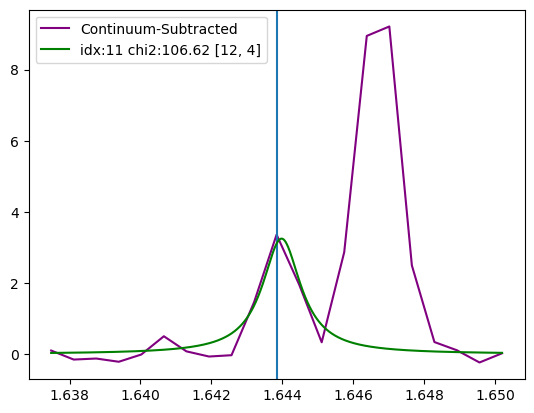

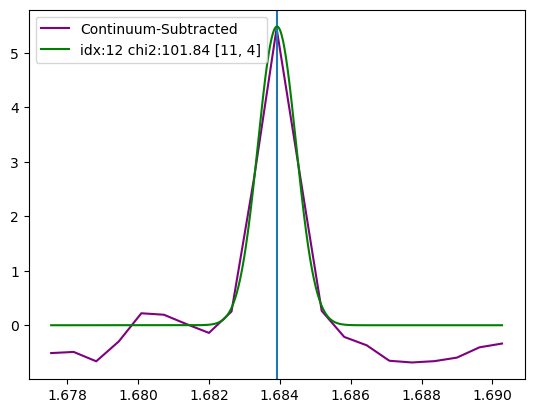

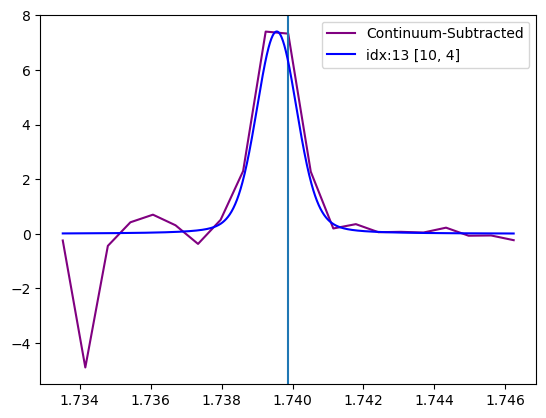

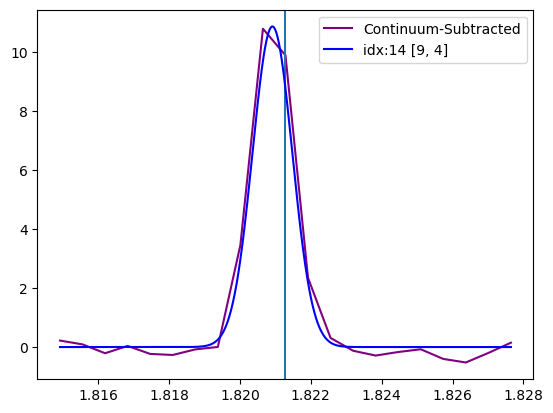

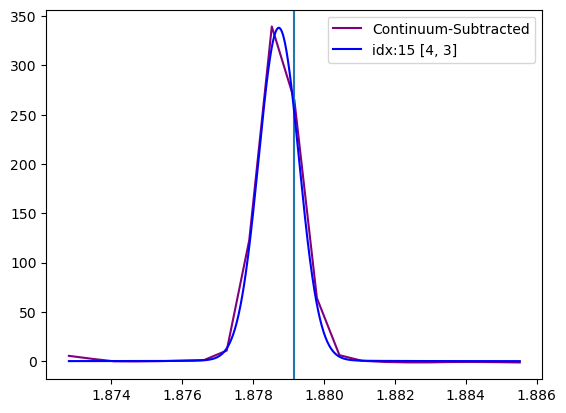

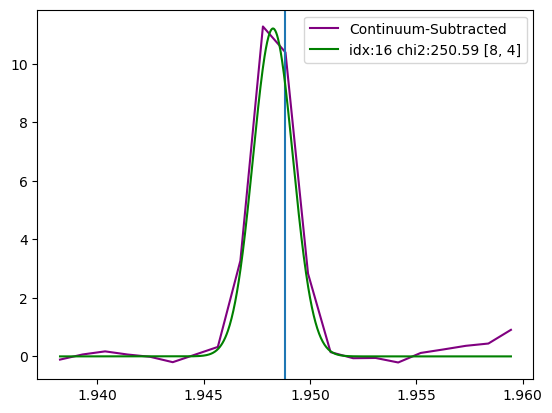

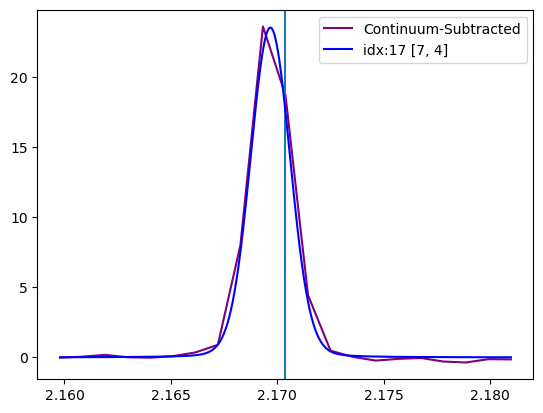

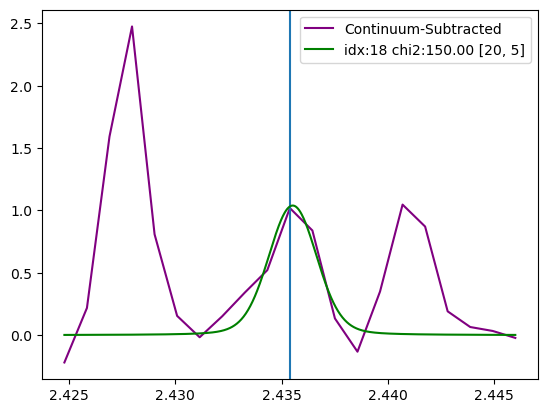

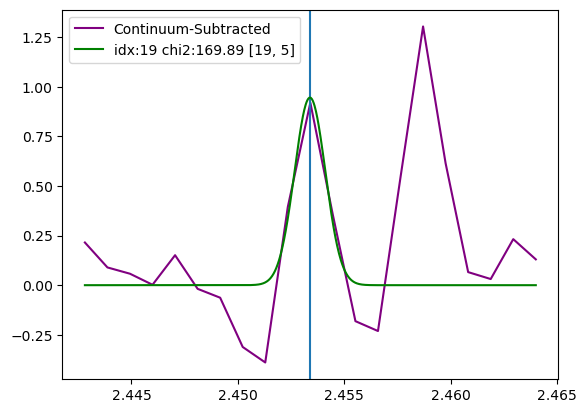

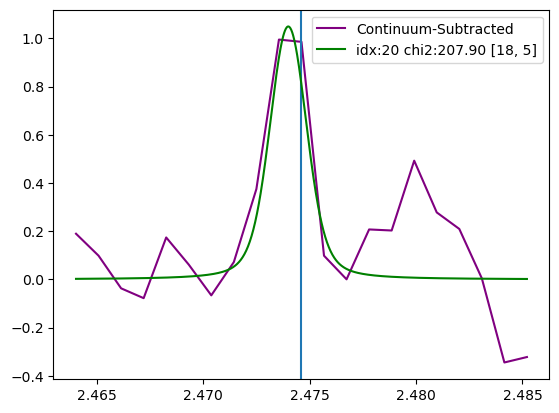

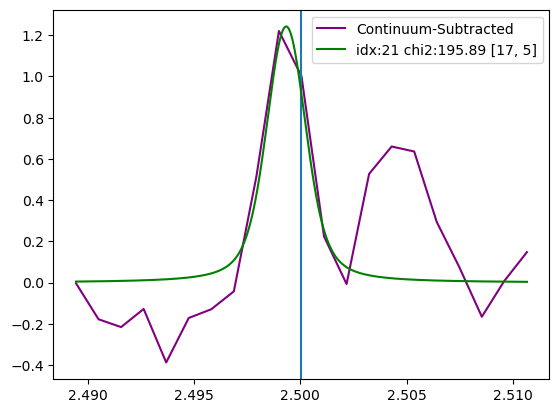

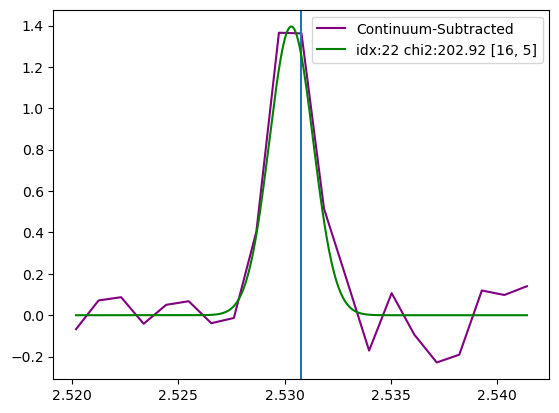

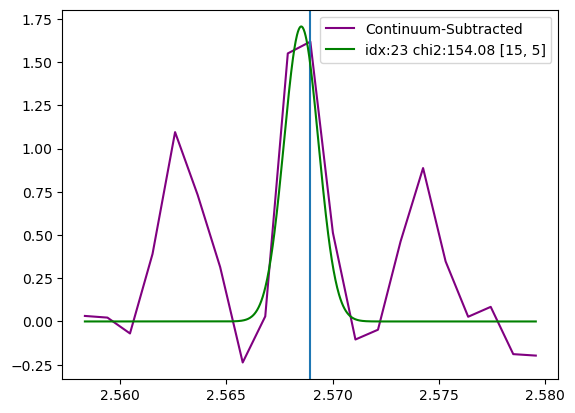

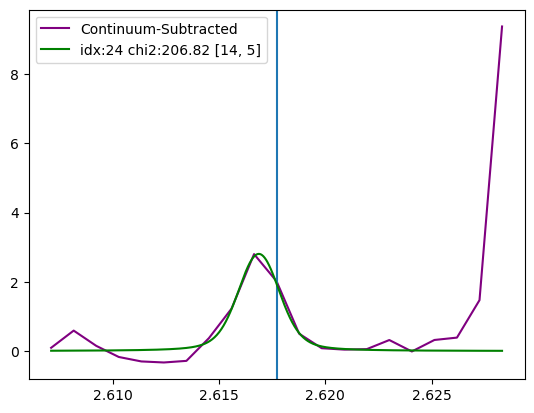

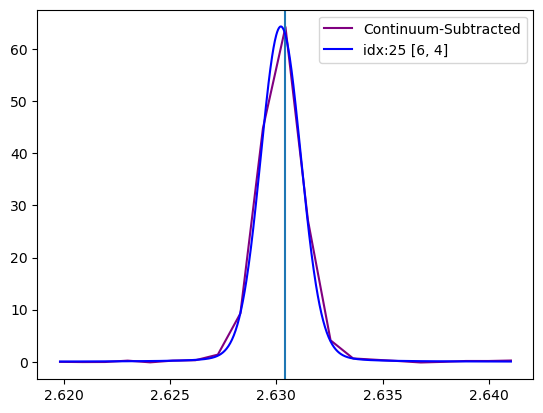

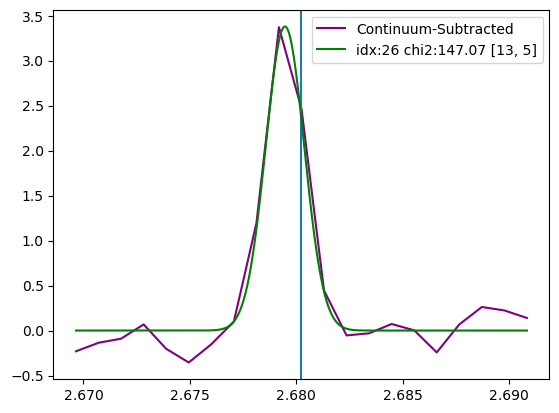

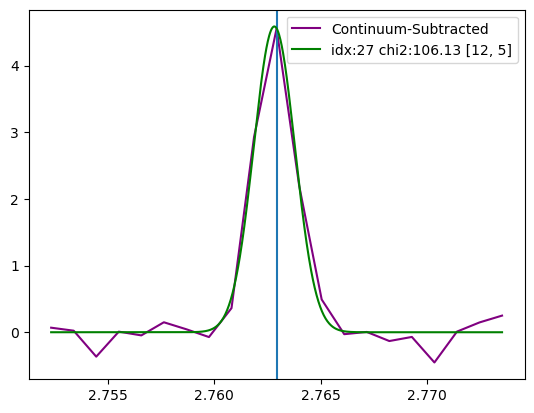

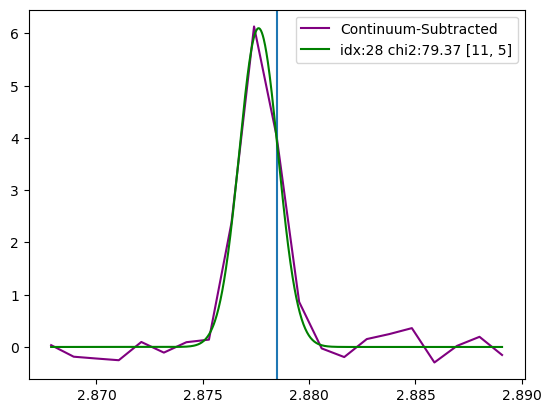

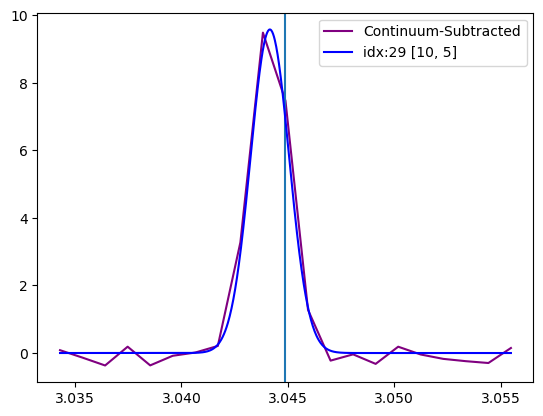

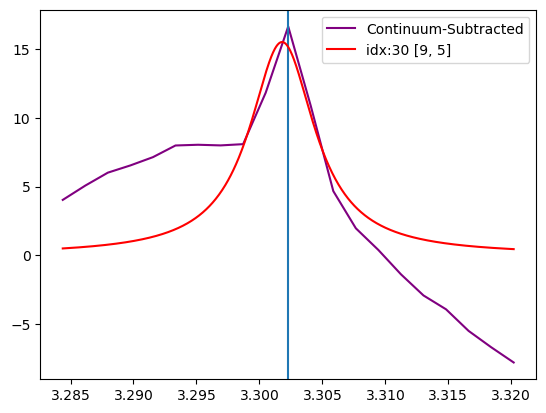

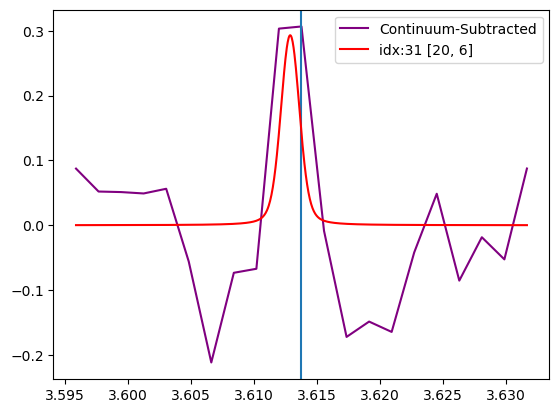

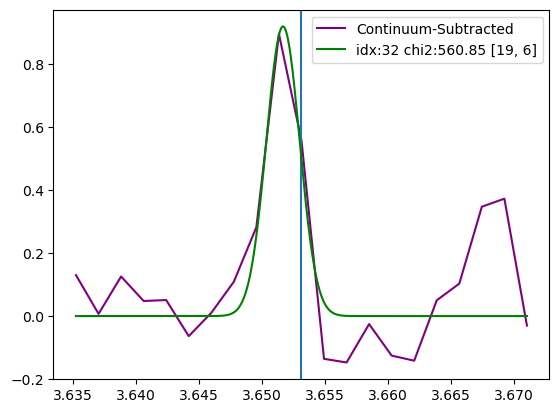

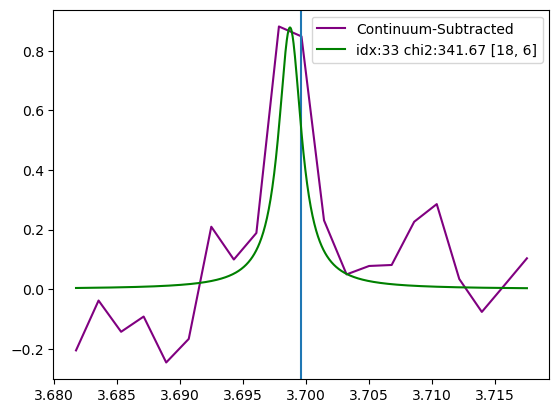

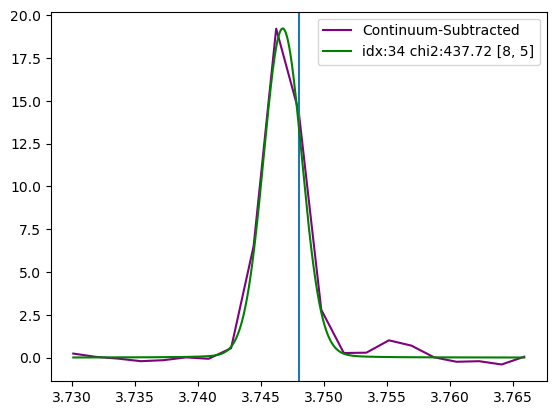

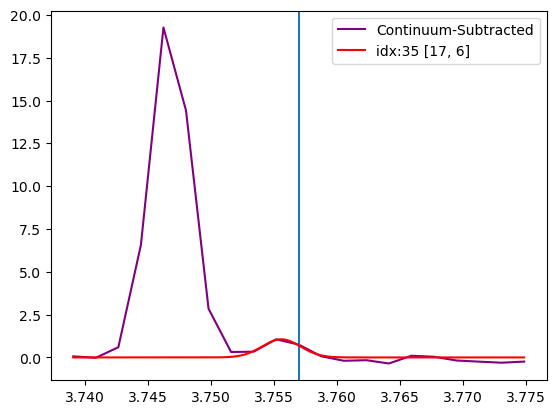

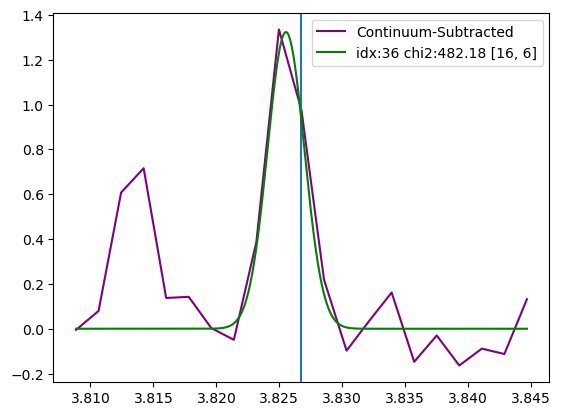

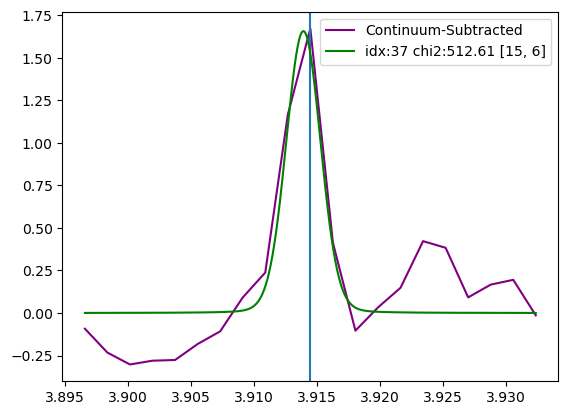

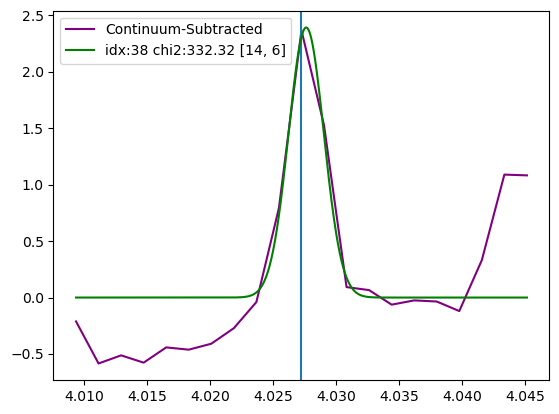

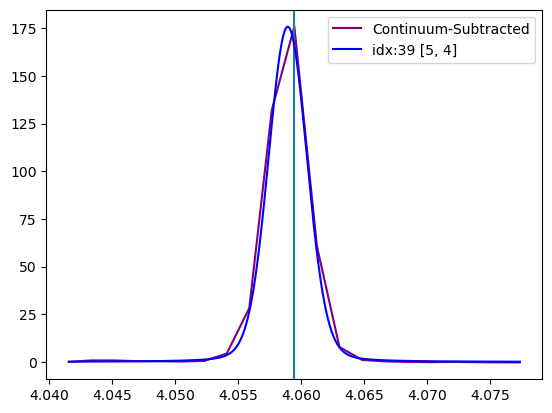

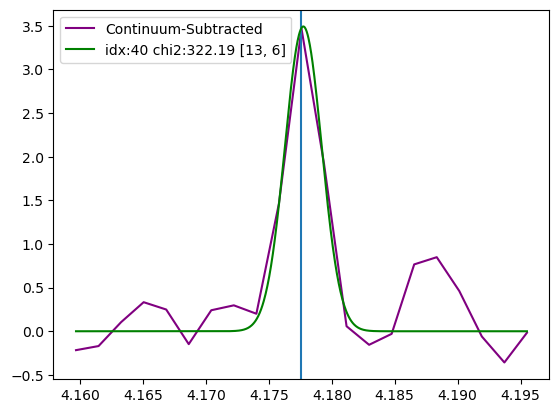

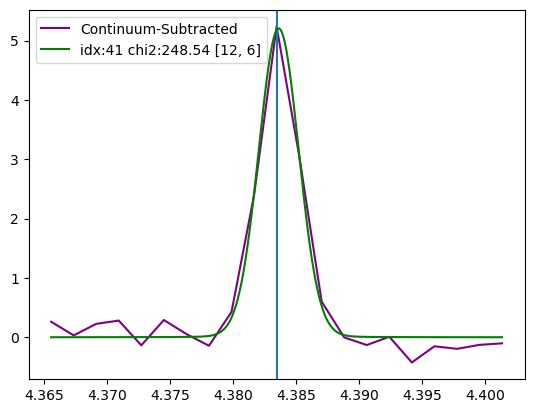

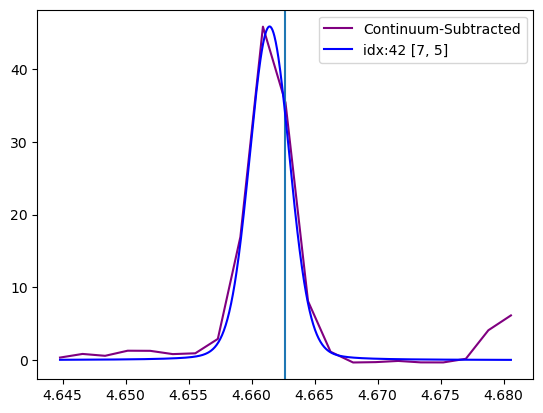

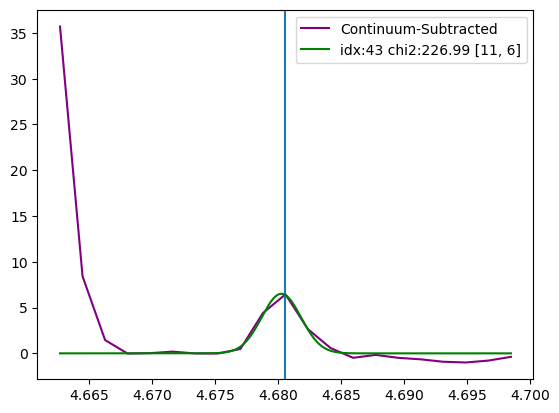

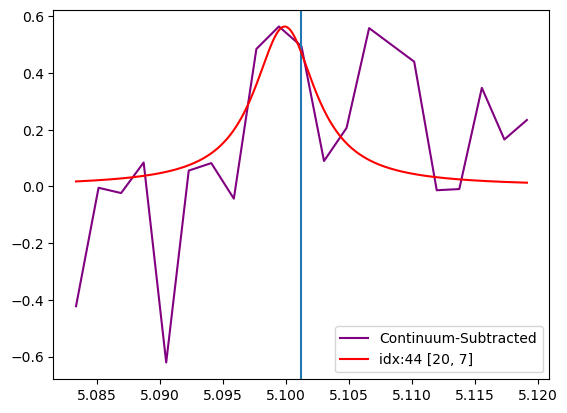

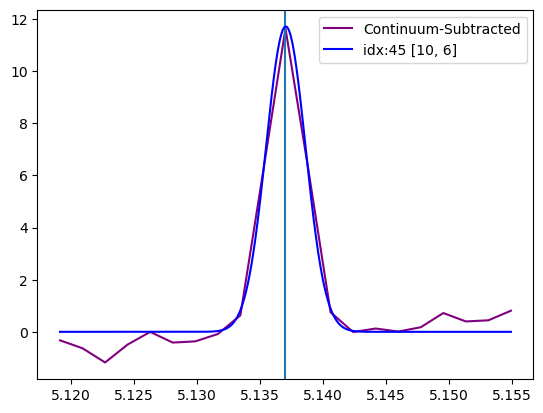

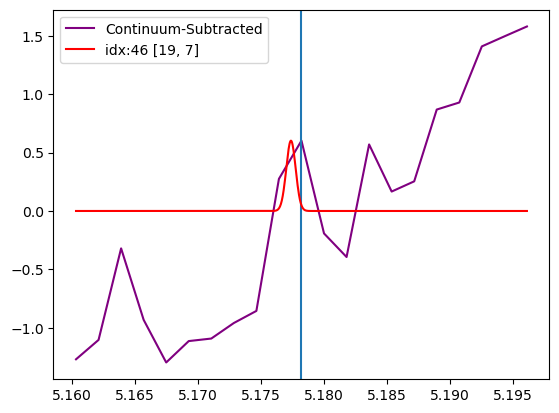

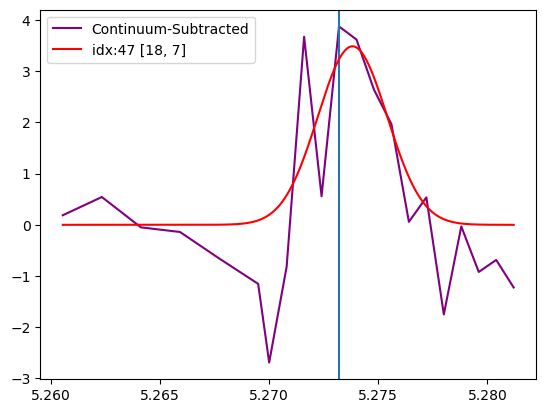

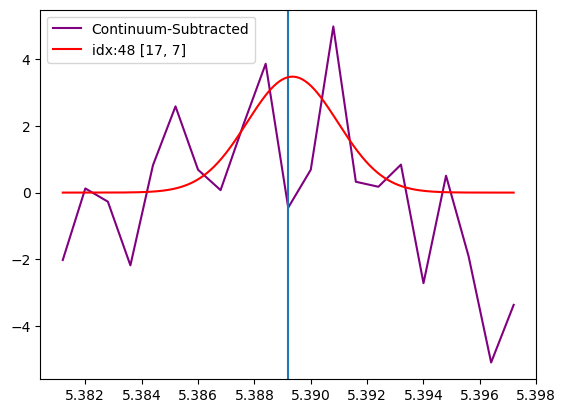

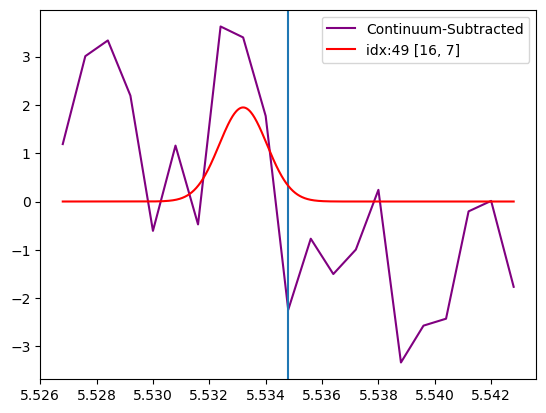

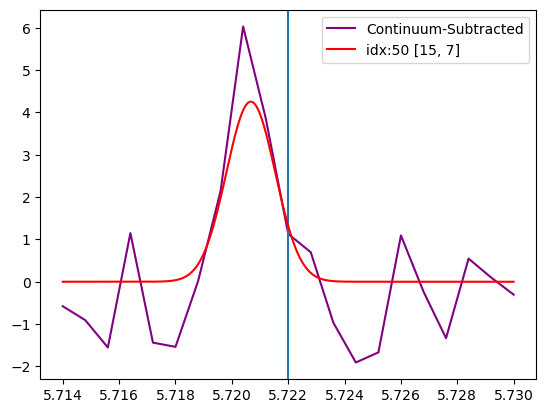

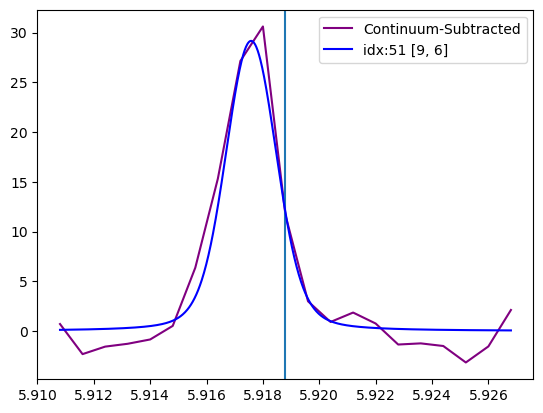

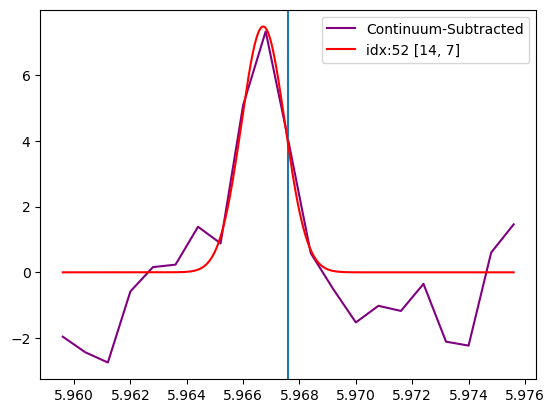

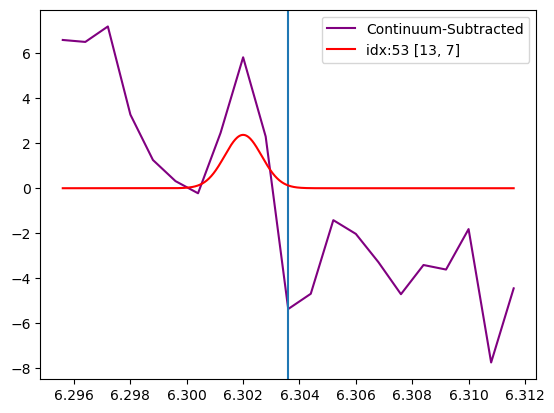

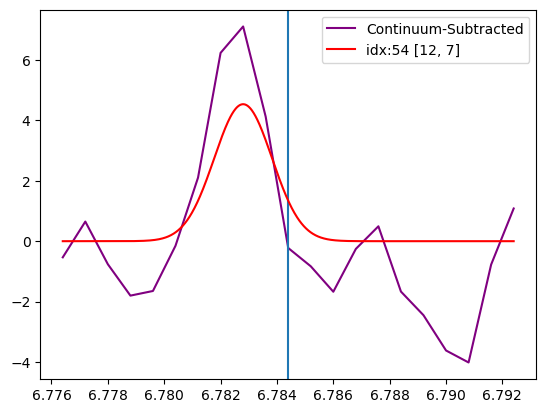

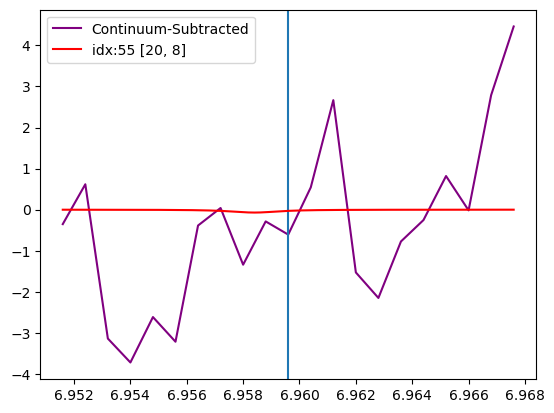

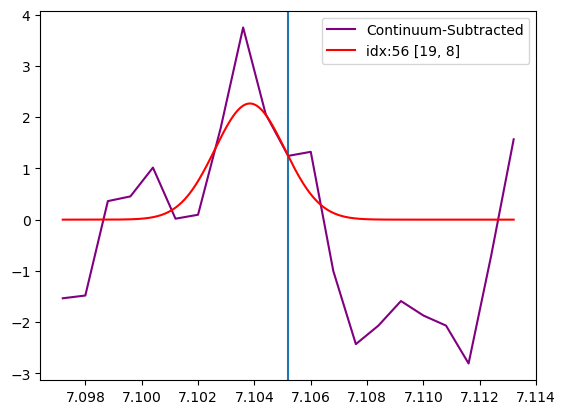

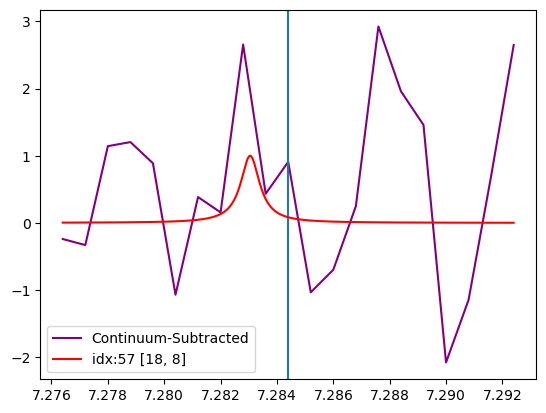

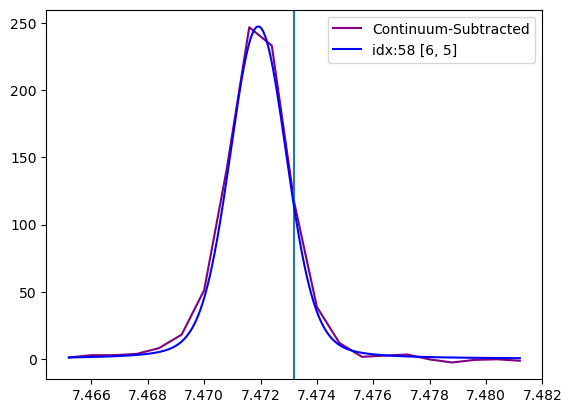

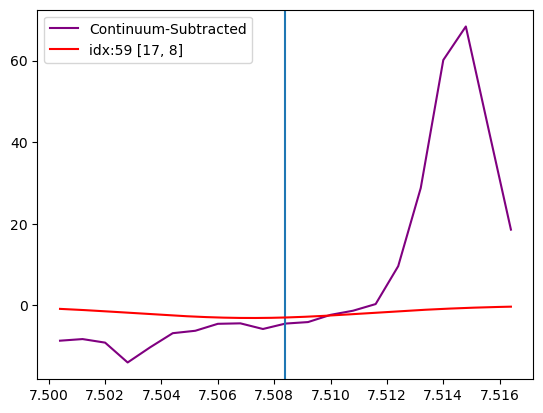

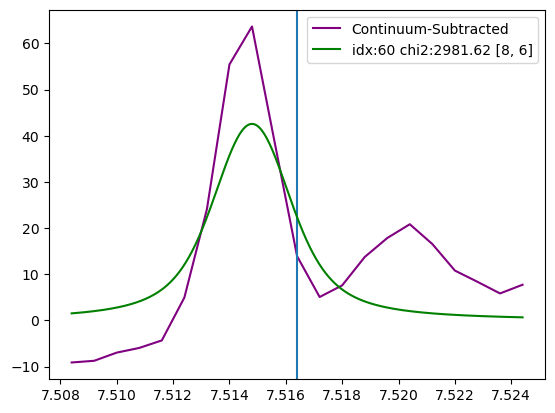

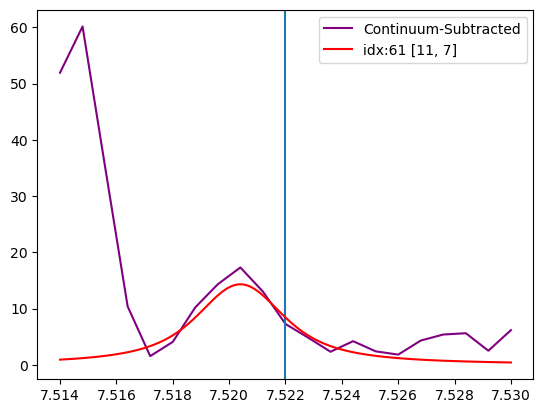

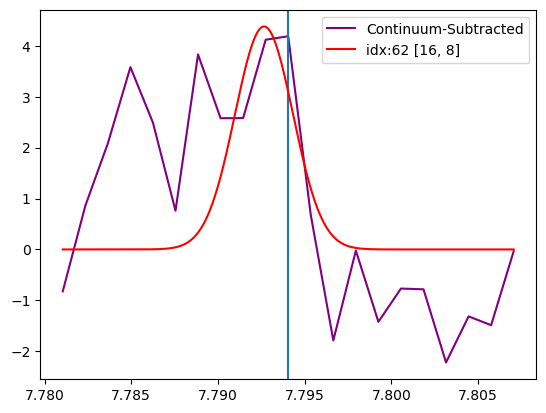

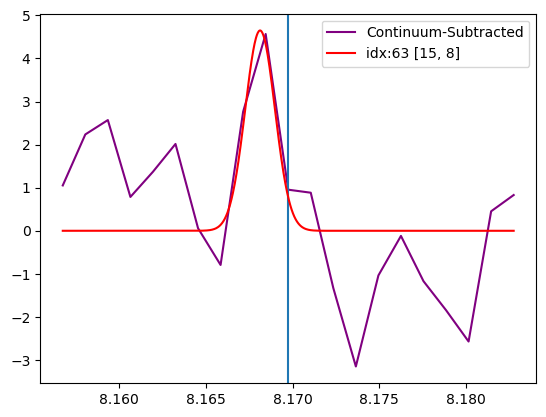

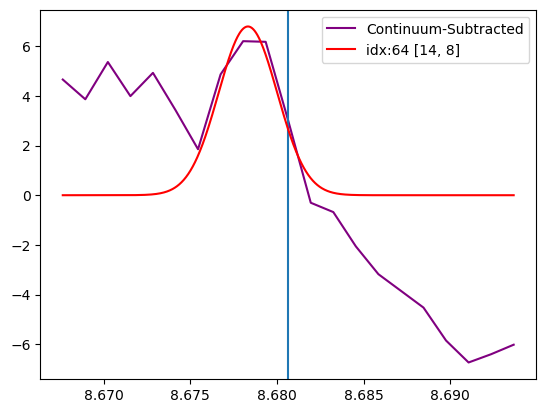

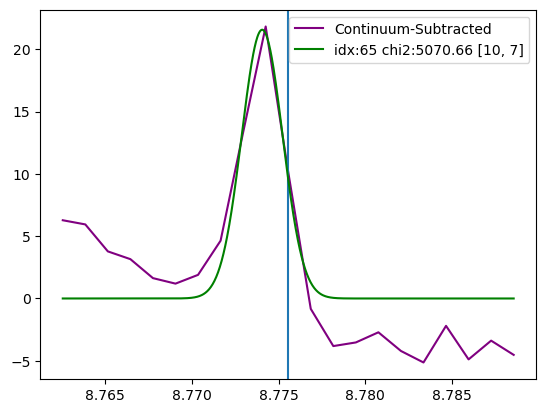

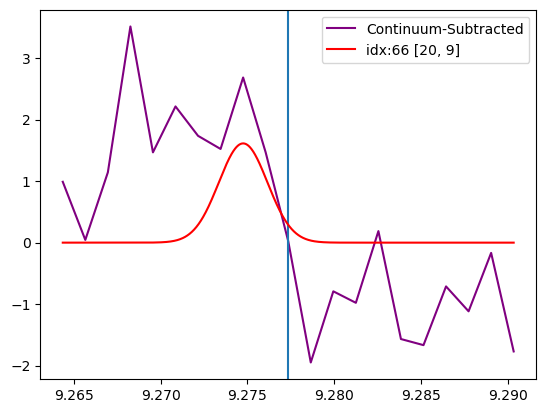

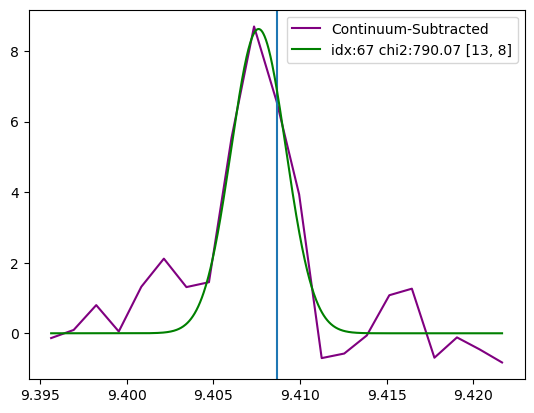

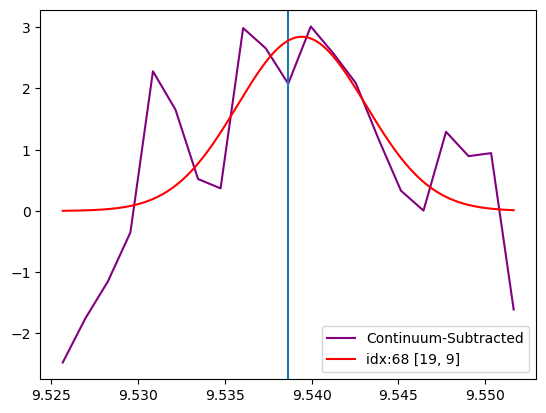

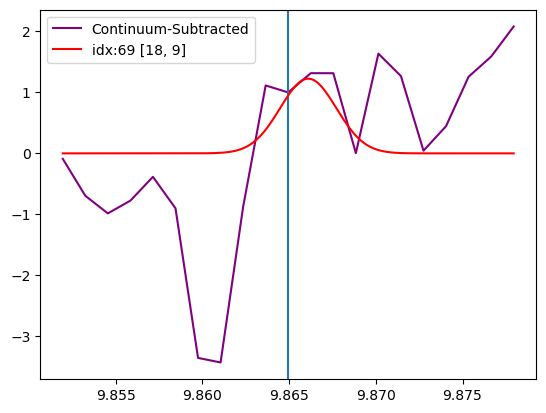

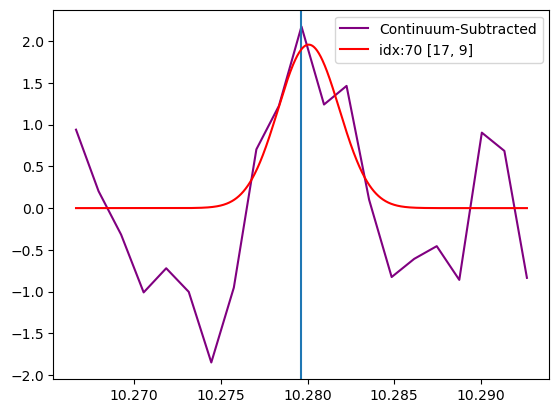

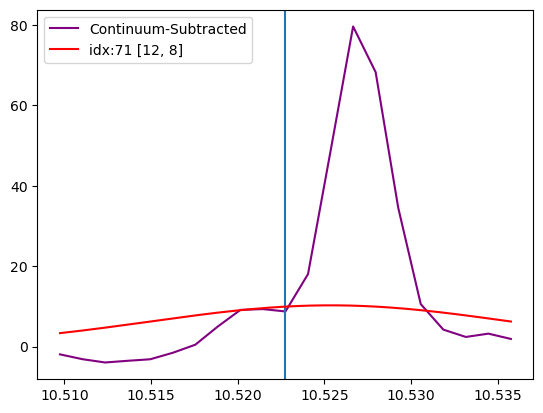

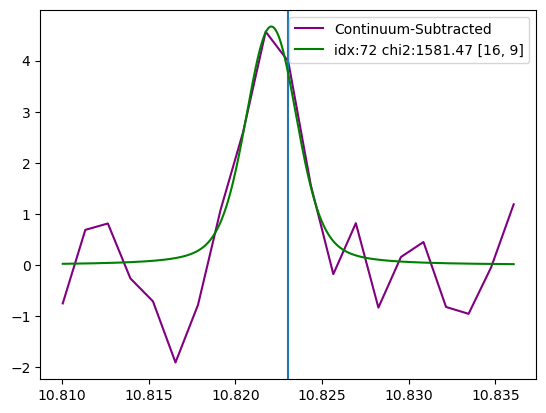

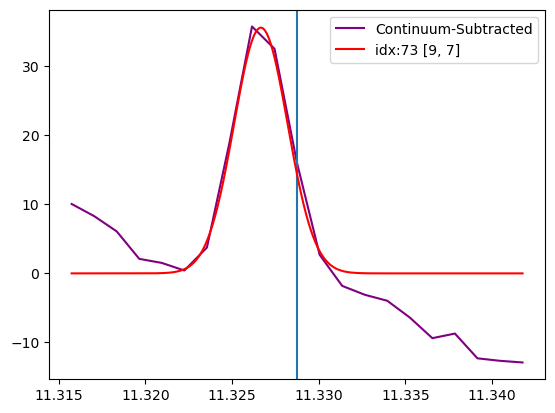

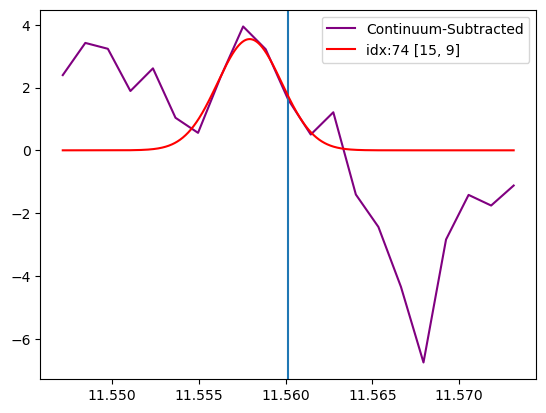

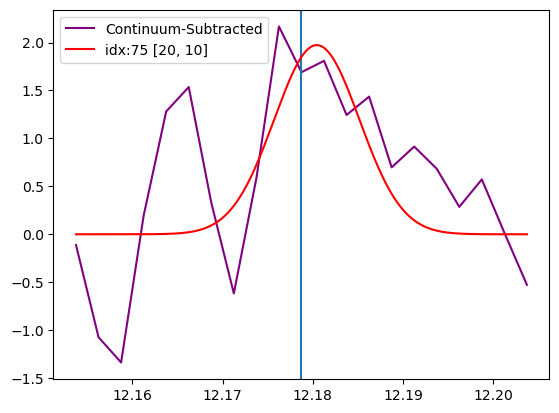

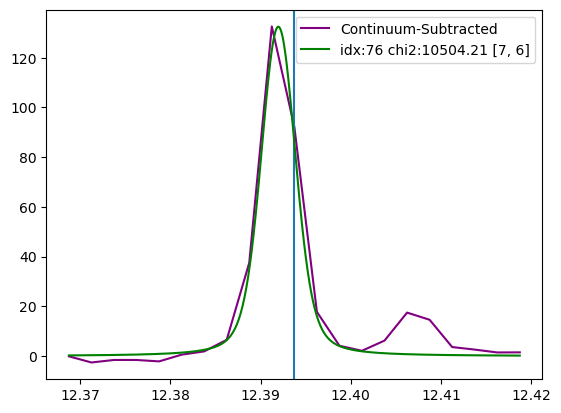

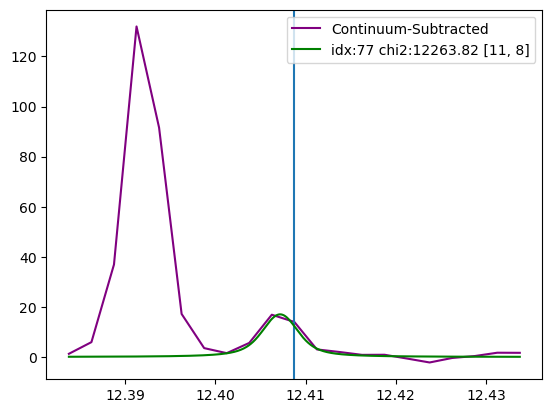

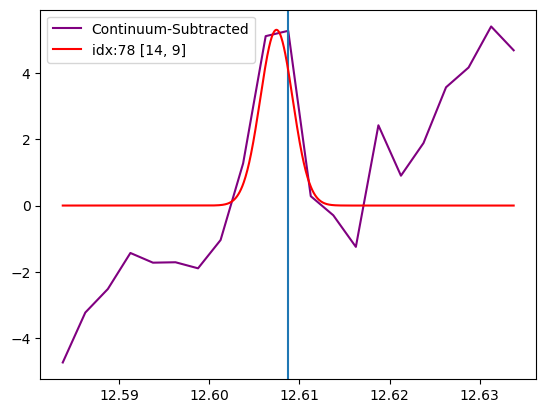

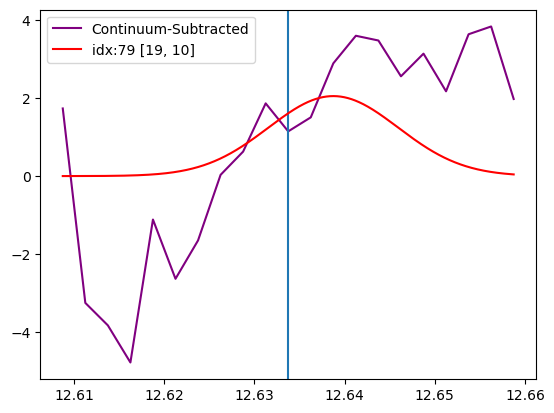

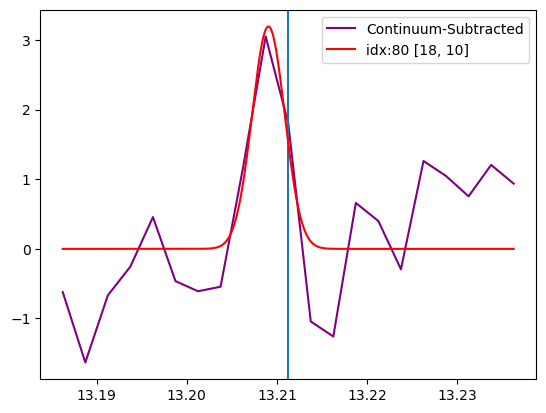

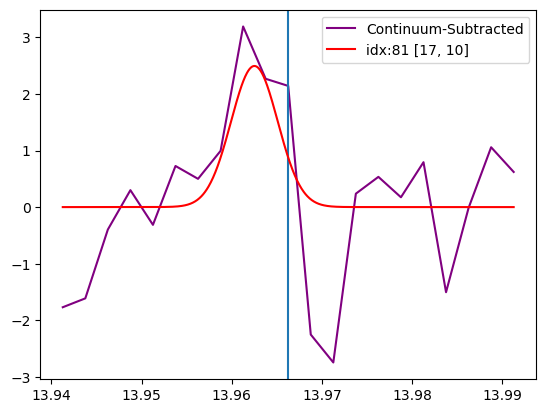

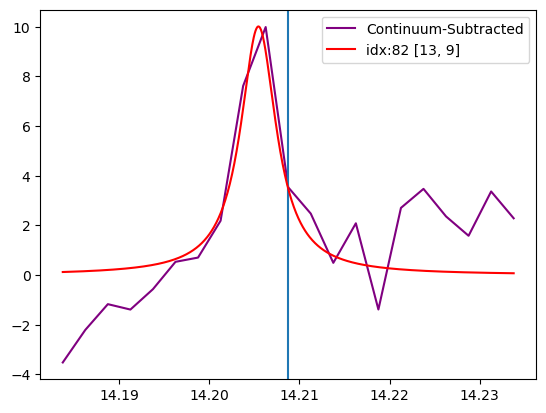

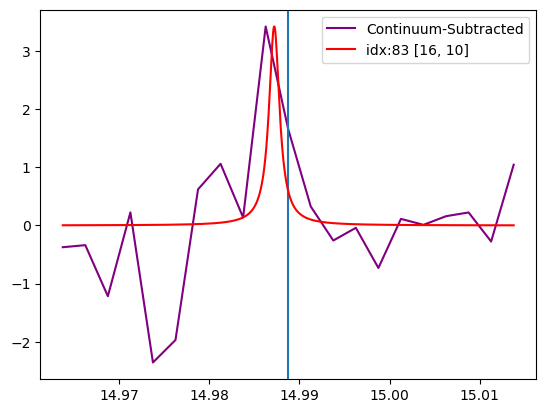

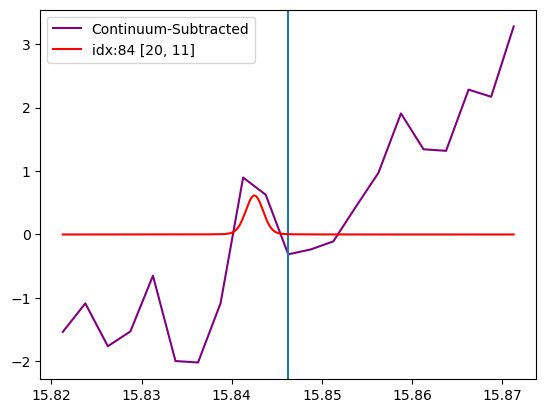

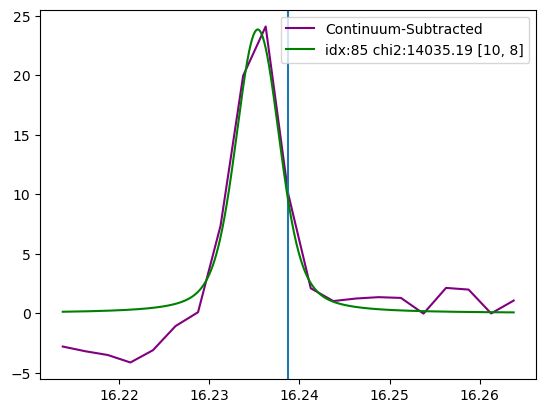

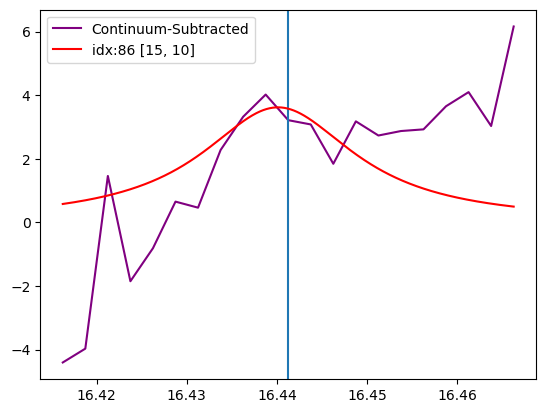

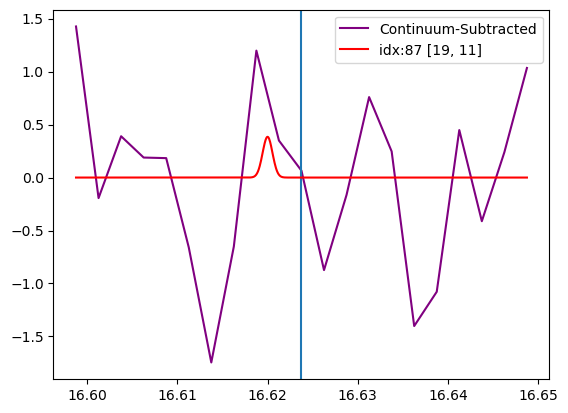

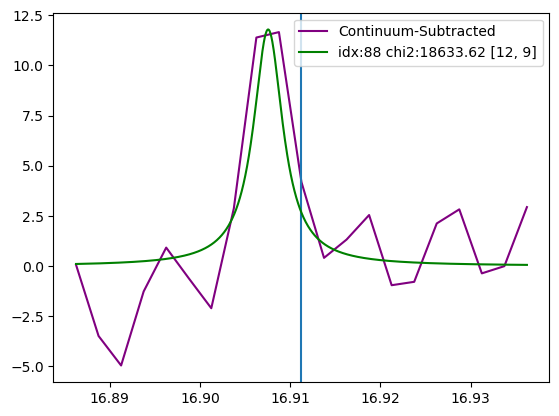

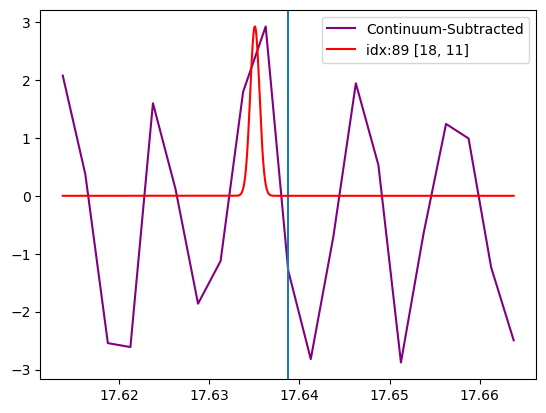

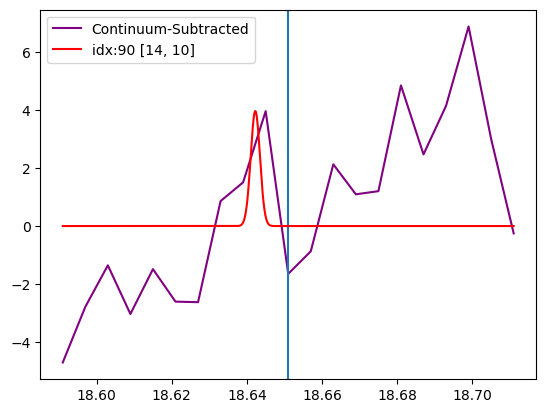

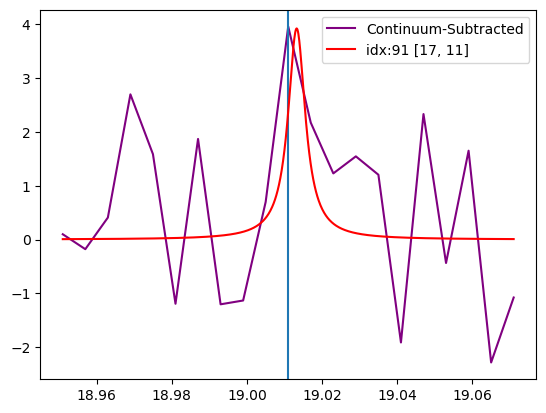

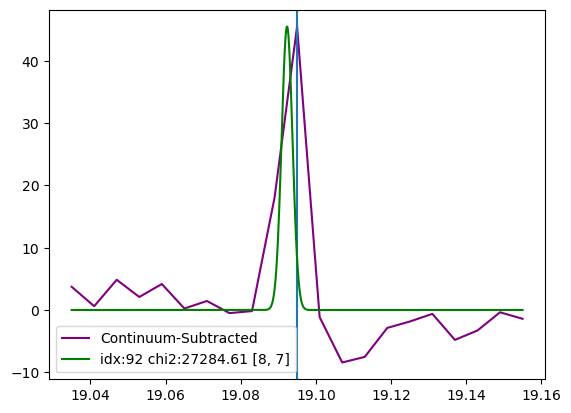

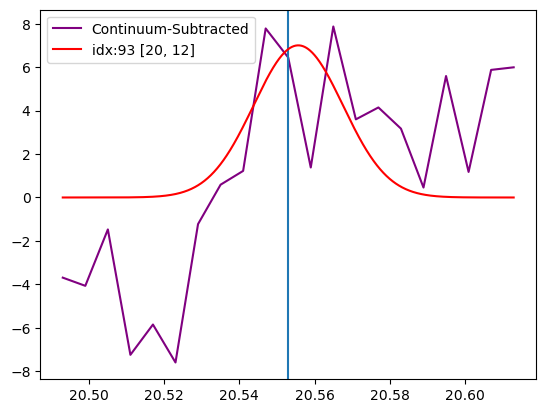

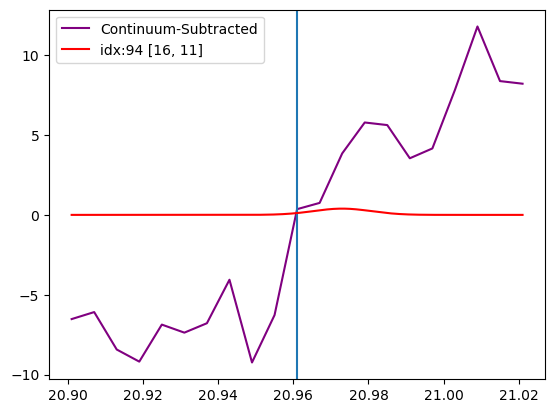

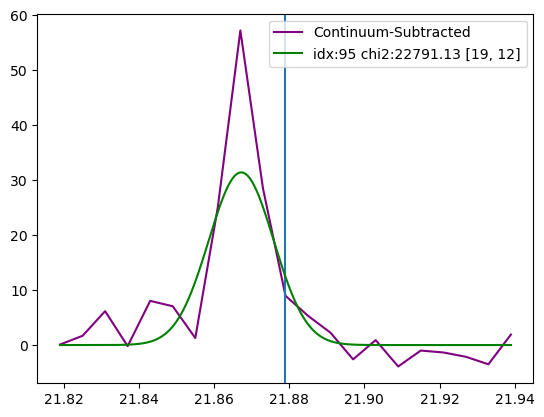

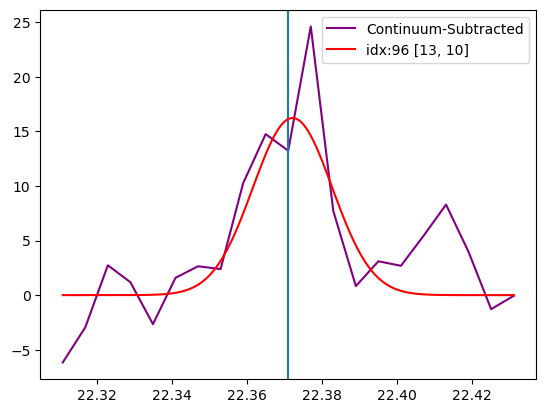

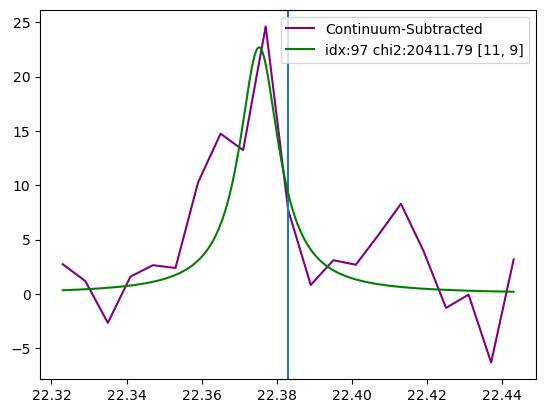

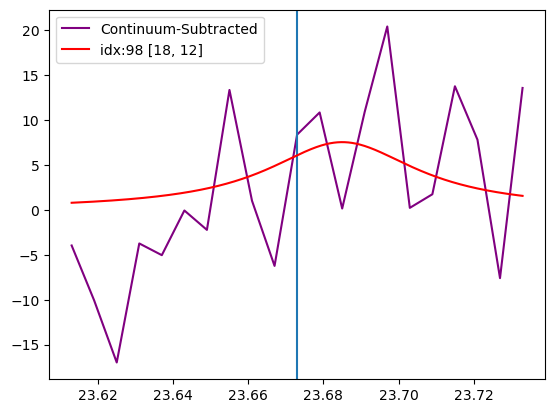

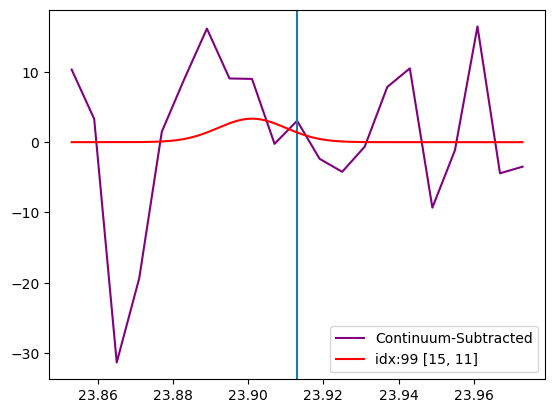

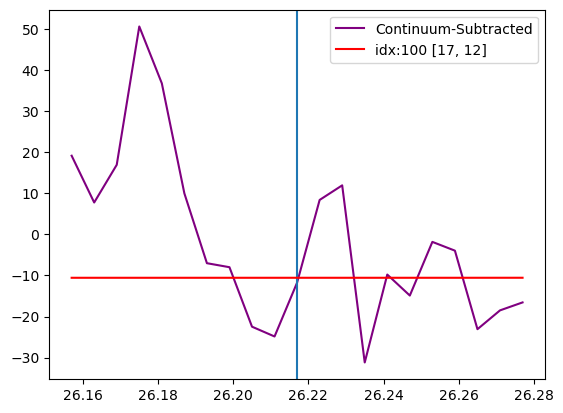

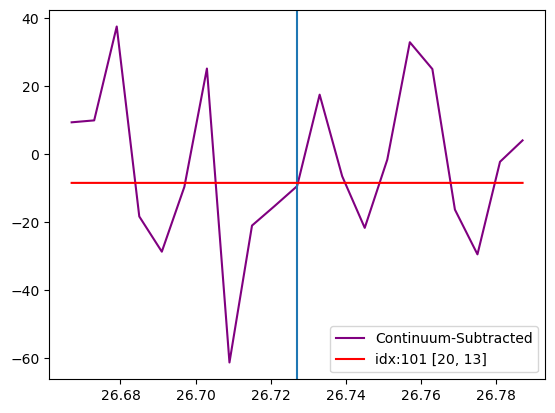

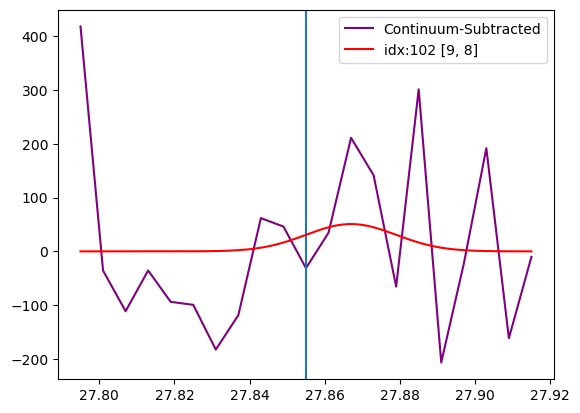

In [3]:
show_plots = True

SED_filepath = 'Data_files/ARM2_HII2_stitch.dat'
data = import_data_and_sort_by_wavelength(SED_filepath)
WL = data[:,0].astype(float)
flux = data[:,1].astype(float)
flux_unc = data[:,2].astype(float)
not_feature_mask = [i == '0' for i in data[:,3]]
feature_mask = [i != '0' for i in data[:,3]]
notes = data[:,4]
trans_wl, transitions = pull_wavelength_data_from_NIST()
voigts = fit_voigt_to_all(WL, flux, flux_unc, feature_mask, trans_wl, transitions, guess_Z = 0.0018)


In [4]:
feature_fluxes, feature_centers, velocities, z = get_feature_statistics(voigts, trans_wl, transitions)

print(f'Velocities : median = {np.nanmedian(velocities):.2f}')
print(f'Velocities : std = {np.nanstd(velocities):.2f}')
print(f'min vel : {np.nanmin(velocities):.2f}')
print(f'max vel : {np.nanmax(velocities):.2f}')
print(f'average redshift : {z}')
print()
g_feature_fluxes, g_feature_centers, g_velocities, g_z = get_good_statistics(voigts, trans_wl, transitions)
print(f'good Velocities : median = {np.nanmedian(g_velocities):.2f}')
print(f'good Velocities : std = {np.nanstd(g_velocities):.2f}')
print(f'min good vel : {np.nanmin(g_velocities):.2f}')
print(f'max good vel : {np.nanmax(g_velocities):.2f}')
print(f'average good redshift : {g_z}')

Velocities : median = 489801.76
Velocities : std = 54354.78
min vel : 346956.48
max vel : 751610.95
average redshift : 0.0016338028180869376

good Velocities : median = 492427.58
good Velocities : std = 24946.63
min good vel : 346956.48
max good vel : 545574.34
average good redshift : 0.0016425616155929473


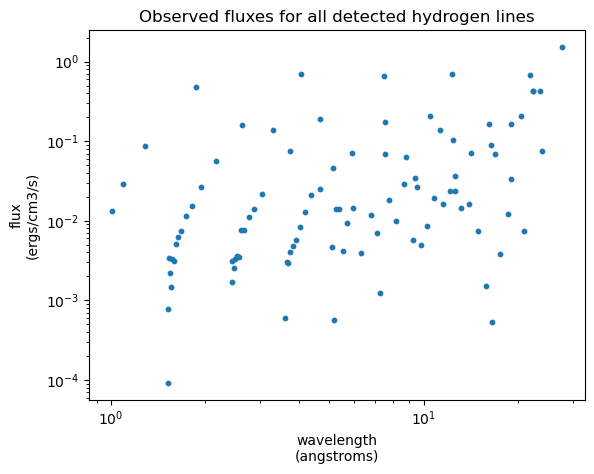

In [23]:
plt.scatter(trans_wl, feature_fluxes, s= 10)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('flux\n(ergs/cm3/s)')
plt.xlabel('wavelength\n(angstroms)')
plt.title('Observed fluxes for all detected hydrogen lines')
plt.show()


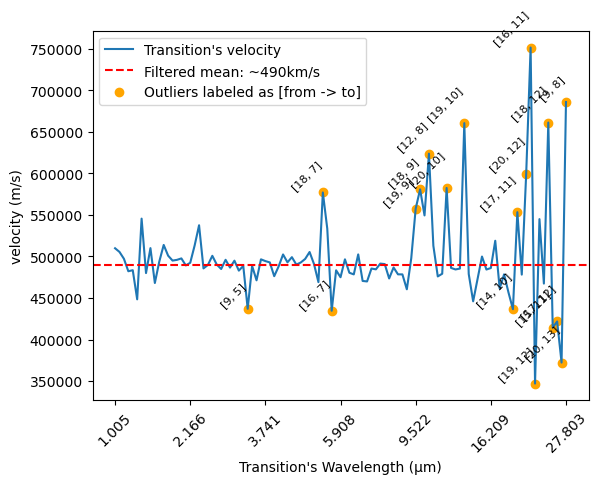

In [26]:

velocities = np.array(velocities, dtype=object)
# Step 1: Compute mean and standard deviation
mean = np.mean(velocities)
std = np.std(velocities)

# Step 2: Apply a sigma-clipping filter (e.g., 3-sigma)
threshold = 1  # change to 2 or another value depending on how strict you want to be
filtered_velocities = velocities[np.abs(velocities - mean) < threshold * std]

# Step 3: Plot original velocities
plt.plot(range(len(velocities)), velocities, label="Transition's velocity")

# Step 4: Plot mean of filtered velocities
mean_filtered = np.mean(filtered_velocities)
plt.axhline(y=mean_filtered, color='red', linestyle='--', label='Filtered mean: ~490km/s')

# Optional: Mark the outliers
outlier_indices = np.where(np.abs(velocities - mean) >= threshold * std)[0]
for i in outlier_indices:
    plt.text(i, velocities[i], transitions[i], fontsize=8, rotation=45, ha='right', va='bottom')

plt.scatter(outlier_indices, velocities[outlier_indices], color='orange', label='Outliers labeled as [from -> to]')
num_ticks = 7
tick_indices = np.linspace(0, len(trans_wl) - 1, num=num_ticks, dtype=int)
tick_labels = [f'{trans_wl[i]:.3f}' for i in tick_indices]
plt.xticks(tick_indices, tick_labels, rotation=45)
plt.xlabel("Transition's Wavelength (μm)")
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

In [ ]:
#previously used function... might be useful to keep
def fit_voigt_to_all(WL, flux, flux_unc, feature_mask, feature_idx, show_plots=True):
    '''Fits voigt profiles to all features

    -------------

    Parameters
    -------------
    WL :  type = array - array of wavelengths including features
    feature_flux :  type = array - flux array for each feature you want to fit
    feature_mask : type = boolean array - 1 if there is a feature at this wavelength, 0 if this is continuum
    feature_idx : type = int - index into the WL array that is the center of the feature
    
    Returns
    -------------
    list of lists where the first entry in each index is the x-values, the second is the y-values describing the voigt function that fit the feature
    '''   
    voigt_funcs = []
    feature_WL, feature_flux, feature_name, feature_idx, feature_unc = get_feature_WL_and_flux(WL, flux, flux_unc, feature_mask, notes)
    print(len(feature_WL), len(feature_idx))
    for i in range(len(feature_idx)):
        continuum, _, _, cont_std = get_continuum_around(WL, flux, feature_mask, feature_idx[i])
        x_data = WL[feature_idx[i]-10:feature_idx[i]+10]
        y_data = flux[feature_idx[i]-10:feature_idx[i]+10] - continuum
        flux_uncertainty = flux_unc[feature_idx[i]-10:feature_idx[i]+10]
        # Initial guesses
        amp_guess = flux[feature_idx[i]]-continuum if (flux[feature_idx[i]]-continuum > 0) else 0
        mean_guess = WL[feature_idx[i]]
        width_guess = WL[feature_idx[i]+1] - WL[feature_idx[i]] if (1 > (WL[feature_idx[i]+1] - WL[feature_idx[i]]) > 0) else 0.001
        
        params, cov = curve_fit(
            voigt,
            x_data,
            y_data,
            p0=[amp_guess, mean_guess, width_guess, width_guess],
            bounds=([0, WL[feature_idx[i]-4], 0, 0], 
                    [np.inf, WL[feature_idx[i]+4], 1.0, 1.0]),
            maxfev = 5000
        )
        xrange = np.linspace(min(x_data),max(x_data), 1000)
        fitted = voigt(xrange, *params)
        this_features_flux = np.trapz(fitted, xrange)
        this_features_snr = params[0]/cont_std
        this_feature_WL = feature_WL[i]
        this_feature_flux = feature_flux[i]
        this_features_unc = feature_unc[i]
        residuals = this_feature_flux - voigt(this_feature_WL, *params)
        chi2 = np.sum((residuals / this_features_unc)**2)
        dof = len(y_data) - len(params)
        reduced_chi2 = chi2 / dof
        voigt_funcs.append([xrange, fitted, params[1], this_features_flux, this_features_snr, reduced_chi2])
        if show_plots:
            plt.plot(WL[feature_idx[i]-10:feature_idx[i]+10], flux[feature_idx[i]-10:feature_idx[i]+10]-continuum, label='Continuum-Subtracted', color='purple')
            if (this_features_snr > 4) & (reduced_chi2/params[0] < 10):
                plt.plot(xrange, fitted, color='blue', label=f'idx:{i} {feature_name[i]}')
            elif this_features_snr > 4:
                plt.plot(xrange, fitted, color='green', label=f'idx:{i} chi2:{reduced_chi2:.2f} {feature_name[i]}')
            else:
                plt.plot(xrange, fitted, color='red', label=f'idx:{i} {feature_name[i]}')
            plt.legend()
            plt.show()
    return voigt_funcs